In [ ]:
#Importing libraries
import os
from PIL import Image, ImageDraw
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import math
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Function for putting all images to the one folder
def consolidate_images(path, destination_path):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)

    # Loop through each subdirectory in the given path
    for person_dir in os.listdir(path):
        # Get the full path for each subdirectory
        person_dir_path = os.path.join(path, person_dir)

        # Copy each image file from the subdirectories to the destination
        for img_file in os.listdir(person_dir_path):
            img_file_path = os.path.join(person_dir_path, img_file)
            shutil.copy2(img_file_path, destination_path)

In [ ]:
#Yield batches of images and labels for training machine learning models
def image_generator(path, batch_size, epochs=1):
    # Load all file names from the specified directory
    file_names = os.listdir(path)
    total_files = len(file_names)

    # Iterate through each epoch
    for epoch in range(epochs):
        # Randomly shuffle the file names for each epoch
        np.random.shuffle(file_names)

        # Iterate over files in batches
        for start in range(0, total_files, batch_size):
            # Define the end of the batch, ensuring it does not exceed total files
            end = min(start + batch_size, total_files)
            # Select a batch of file names
            batch_files = file_names[start:end]

            # Initialize lists to store batch data and labels
            batch_data = []
            batch_labels = []

            # Process each file in the batch
            for file_name in batch_files:
                # Generate the full path for the image and load it
                img_path = os.path.join(path, file_name)
                img = Image.open(img_path).convert('RGB')
                # Convert the image to an array and normalize pixel values
                img = img_to_array(img) / 255.0
                # Extract the label from the file name
                label = file_name.split('.')[0][-3:-1]

                # Append the image and label to their respective lists
                batch_data.append(img)
                batch_labels.append(label)

            # Yield the batch data and labels as NumPy arrays
            yield np.array(batch_data, dtype=np.float32), np.array(batch_labels)

In [ ]:
#Yield only batch data in format for autoencoder
def autoencoder_generator(image_gen):
    for batch_data, _ in image_gen:
        yield batch_data, batch_data

In [ ]:
#Yield only batch data in format for predictions
def autoencoder_generator_pred(image_gen):
    for batch_data, _ in image_gen:
        yield batch_data

In [ ]:
def encoder(inputs):
    # First layer: Convolutional layer with 128 filters followed by batch normalization and max pooling
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Second layer: Similar structure with 64 filters
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Third layer: Reduces to 32 filters, completes the encoding process
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return encoded

def decoder(encoded):
    # Decoder begins with a deconvolutional layer, expanding feature maps
    x = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)

    # Increases complexity by upscaling and doubling the number of filters
    x = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Final layer to upscale to original dimensions with 128 filters
    x = Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    # Reconstruction of the original input
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return decoded

# Define batch size and input image dimensions
batch_size = 8
input_img = Input(shape=(1000, 800, 3))
# Build the autoencoder using the encoder and decoder functions
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)
# Optimizer adapts learning rate based on batch size, using Adam optimizer
optimizer = Adam(learning_rate=0.01*(batch_size/256), beta_1=0.9, beta_2=0.999)
# Compile the model with mean squared error as the loss function
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Display the model's architecture
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 800, 3)]    0         
                                                                 
 conv2d (Conv2D)             (None, 1000, 800, 128)    3584      
                                                                 
 batch_normalization (Batch  (None, 1000, 800, 128)    512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 500, 400, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 500, 400, 64)      73792     
                                                                 
 batch_normalization_1 (Bat  (None, 500, 400, 64)      256   

In [ ]:
# Use function and put all files to the one folder
consolidate_images('/content/drive/My Drive/Colab Notebooks/IIITM_Face_Emotion_dataset', '/content/drive/My Drive/Colab Notebooks/IIITM_Face_Emotion_dataset_consolidated')

In [ ]:
# Initialize the image generator with dataset path, batch size, and epochs.
generator = image_generator('/content/drive/My Drive/Colab Notebooks/IIITM_Face_Emotion_dataset_consolidated', batch_size, epochs=100)

# Wrap the image generator with an autoencoder.
autoencoder_gen = autoencoder_generator(generator)

# Set the total number of images in the dataset.
total_images = 1926

# Calculate the number of steps per epoch.
steps = math.ceil(total_images / batch_size)

In [ ]:
# Initialize model checkpointing to save the model with the lowest loss.
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/model.h5', monitor='loss', save_best_only=True, mode='min', verbose=1)

# Set up early stopping to halt training if loss doesn't improve after 20 epochs.
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True, mode='min', verbose=1)

# Configure learning rate reduction if loss doesn't improve after 3 epochs.
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1, factor=0.5, min_lr=0.0000001)

In [ ]:
# Train the autoencoder model with specified epochs, steps per epoch, and callbacks for checkpointing, early stopping, and learning rate reduction.
autoencoder.fit(autoencoder_gen, epochs=100, steps_per_epoch=steps, callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/100
241/241 [==============================] - ETA: 0s - loss: 0.0141
Epoch 1: loss improved from inf to 0.01408, saving model to /content/drive/My Drive/Colab Notebooks/model.h5
241/241 [==============================] - 97s 326ms/step - loss: 0.0141 - lr: 3.1250e-04
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


241/241 [==============================] - ETA: 0s - loss: 0.0024
Epoch 2: loss improved from 0.01408 to 0.00241, saving model to /content/drive/My Drive/Colab Notebooks/model.h5
241/241 [==============================] - 70s 290ms/step - loss: 0.0024 - lr: 3.1250e-04
Epoch 3/100
241/241 [==============================] - ETA: 0s - loss: 0.0019
Epoch 3: loss improved from 0.00241 to 0.00193, saving model to /content/drive/My Drive/Colab Notebooks/model.h5
241/241 [==============================] - 70s 289ms/step - loss: 0.0019 - lr: 3.1250e-04
Epoch 4/100
241/241 [==============================] - ETA: 0s - loss: 0.0018
Epoch 4: loss improved from 0.00193 to 0.00178, saving model to /content/drive/My Drive/Colab Notebooks/model.h5
241/241 [==============================] - 70s 290ms/step - loss: 0.0018 - lr: 3.1250e-04
Epoch 5/100
241/241 [==============================] - ETA: 0s - loss: 0.0019
Epoch 5: loss did not improve from 0.00178
241/241 [==============================] - 69s 2

In [ ]:
# Load the best model
autoencoder = load_model('/content/drive/My Drive/Colab Notebooks/model.h5')

In [ ]:
# Create a prediction generator using the image dataset for the autoencoder model.
predict_generator = autoencoder_generator_pred(image_generator('/content/drive/My Drive/Colab Notebooks/IIITM_Face_Emotion_dataset_consolidated', batch_size, epochs=1))

# Initialize an empty list to store predictions.
predictions = []

# Loop through the prediction generator and make predictions for each batch.
for batch_data in predict_generator:
    prediction = autoencoder.predict(batch_data)
    # Extend the predictions list with the results from the current batch.
    predictions.extend(prediction)

1/1 [==============================] - 0s 45ms/step


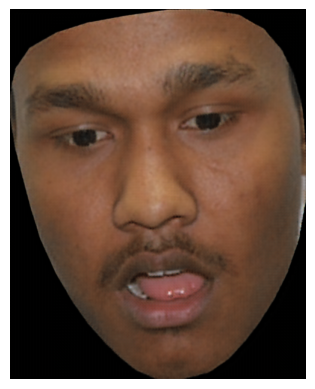

In [ ]:
# Display image from the predictions list without the axis.
plt.imshow(predictions[1001])
plt.axis('off')
plt.show()

In [ ]:
# Initialize a generator for encoding prediction using the specified dataset.
encode_predict_generator = image_generator('/content/drive/My Drive/Colab Notebooks/IIITM_Face_Emotion_dataset_consolidated', batch_size, epochs=1)

# Define the encoder model from the autoencoder architecture.
encoder_model = Model(input_img, encoded)

# Initialize lists to store encoded images and their corresponding labels.
encoded_images = []
all_labels = []

# Loop through the generator and encode each batch of images.
for batch_data, batch_labels in encode_predict_generator:
    encoded_batch = encoder_model.predict(batch_data)
    # Append the encoded batch and labels to their respective lists.
    encoded_images.extend(encoded_batch)
    all_labels.extend(batch_labels)

# Convert the lists of encoded images and labels to NumPy arrays.
encoded_images_np = np.array(encoded_images)
all_labels_np = np.array(all_labels)

# Save the encoded images and labels as a compressed .npz file.
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/encoded_data.npz', encoded_images=encoded_images_np, labels=all_labels_np)

1/1 [==============================] - 0s 63ms/step
